# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from tensorly import tenalg
import tensorly as tl
from sklearn.metrics import mean_squared_error as mse

from time import time

torch.manual_seed(0)

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [2]:
def tensor_mul_mat(tensor, list_of_mat):
    """Возвращает произведение тензора на матрицы"""
    D = tensor.reshape(tensor.shape[0], -1)
    res = tl.matmul(tl.tensor(D.T), tl.tensor(list_of_mat[0].T)).reshape(tensor.shape[1], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[1].T)).reshape(tensor.shape[2], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[2].T)).reshape((list_of_mat[0].shape[0], 
                                                      list_of_mat[1].shape[0], 
                                                      list_of_mat[2].shape[0])) + np.random.normal(0.01, .1) # random noise
    return res

In [3]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
        
        
    res = tensor_mul_mat(G, U)
    
    return res, U, G

res, U, G = get_tensor()

In [4]:
res

array([[[2357520.84587271, 2466959.84587271, 2058944.84587271, ...,
         1986481.84587271, 2148796.84587271, 2316930.84587271],
        [4041339.84587271, 4182637.84587271, 3511537.84587271, ...,
         3374913.84587271, 3661673.84587271, 3949856.84587271],
        [3068743.84587271, 3169407.84587271, 2670444.84587271, ...,
         2567379.84587271, 2766798.84587271, 3002912.84587271],
        ...,
        [2507990.84587271, 2602852.84587271, 2171123.84587271, ...,
         2111545.84587271, 2269993.84587271, 2443544.84587271],
        [3316024.84587271, 3457073.84587271, 2863030.84587271, ...,
         2787857.84587271, 3014860.84587271, 3252410.84587271],
        [3066578.84587271, 3198470.84587271, 2674959.84587271, ...,
         2583332.84587271, 2818797.84587271, 3008669.84587271]],

       [[2189060.84587271, 2279263.84587271, 1899903.84587271, ...,
         1831756.84587271, 1982857.84587271, 2140519.84587271],
        [3712855.84587271, 3841984.84587271, 3199409.84587271

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [5]:
data, U, G = get_tensor(size=(10, 10, 10), r=(2, 2, 2))
data.shape, [u.shape for u in U], G.shape
data

array([[[ 1684.18031176,  3492.18031176,   952.18031176,   464.18031176,
          1220.18031176,  2416.18031176,  2344.18031176,  1344.18031176,
          2272.18031176,  1196.18031176],
        [ 1876.18031176,  3816.18031176,  1054.18031176,   506.18031176,
          1370.18031176,  2698.18031176,  2572.18031176,  1434.18031176,
          2446.18031176,  1328.18031176],
        [ 3550.18031176,  7272.18031176,  1999.18031176,   965.18031176,
          2585.18031176,  5101.18031176,  4894.18031176,  2757.18031176,
          4687.18031176,  2516.18031176],
        [ 2592.18031176,  5292.18031176,  1458.18031176,   702.18031176,
          1890.18031176,  3726.18031176,  3564.18031176,  1998.18031176,
          3402.18031176,  1836.18031176],
        [ 3560.18031176,  7308.18031176,  2006.18031176,   970.18031176,
          2590.18031176,  5114.18031176,  4916.18031176,  2778.18031176,
          4718.18031176,  2524.18031176],
        [ 2360.18031176,  4824.18031176,  1328.18031176,   6

## 2 Реализуйте метод для восстановления тензора по разложению

In [6]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U):
    data = tensor_mul_mat(G_, U)
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц
    # G_ - ядро разложения

    return data

In [7]:
rep_tensor = repair_tensor(G, U)
rep_tensor

array([[[ 1683.95545932,  3491.95545932,   951.95545932,   463.95545932,
          1219.95545932,  2415.95545932,  2343.95545932,  1343.95545932,
          2271.95545932,  1195.95545932],
        [ 1875.95545932,  3815.95545932,  1053.95545932,   505.95545932,
          1369.95545932,  2697.95545932,  2571.95545932,  1433.95545932,
          2445.95545932,  1327.95545932],
        [ 3549.95545932,  7271.95545932,  1998.95545932,   964.95545932,
          2584.95545932,  5100.95545932,  4893.95545932,  2756.95545932,
          4686.95545932,  2515.95545932],
        [ 2591.95545932,  5291.95545932,  1457.95545932,   701.95545932,
          1889.95545932,  3725.95545932,  3563.95545932,  1997.95545932,
          3401.95545932,  1835.95545932],
        [ 3559.95545932,  7307.95545932,  2005.95545932,   969.95545932,
          2589.95545932,  5113.95545932,  4915.95545932,  2777.95545932,
          4717.95545932,  2523.95545932],
        [ 2359.95545932,  4823.95545932,  1327.95545932,   6

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [8]:
def get_tensor_box(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
    

    res = tensor_mul_mat(G, U)
    
    data_box = tenalg.multi_mode_dot(G, U)
    
    return res, data_box, U, G

a1, a2, U, G = get_tensor_box(r=(10, 10, 10))
loss = np.linalg.norm(a1 - a2)
loss

33.488466393860726

Не забудьте померить ошибку разложения по метрике MSE

In [9]:
print('MSE:', mse(a1.flatten(), a2.flatten()))

MSE: 0.0003738257938042556


# HW 2 - Разложение матриц градиентным методом. Part 2

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [10]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Opt(Optimizer):

    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        
        if not self.state:
            self.state["step"] = 1
        else:
            self.state["step"] += 1

    
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad_param = param.grad.data
                param.data -= group['lr']*grad_param
        

        return loss

In [11]:
device = 'cuda'
tl.set_backend('pytorch')
t1 = time()
rep_tensor = tl.tensor(repair_tensor(G,U), device=device, requires_grad=True)
t2 = time()

D:\anaconda\envs\fruitjuice\lib\site-packages\tensorly\backend\pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


In [12]:
ranks = [10, 10, 10]
core = tl.tensor(torch.randint(0, 10, (ranks)).double(), device=device, requires_grad=True)
factors = [tl.tensor(torch.randint(0, 10, (rep_tensor.shape[i], ranks[i])).double(), device=device, requires_grad=True) 
           for i in range(np.ndim(rep_tensor))]

In [13]:
[i.shape for i in factors]

[torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([150, 10])]

In [14]:
core.shape

torch.Size([10, 10, 10])

In [15]:
n_iter = 60
lr = 0.0000005
penalty = 0.1
points = []
errors = []

optimizer = Opt([core]+factors, lr=lr)

for i in range(n_iter + 1):
    # reset grad
    optimizer.zero_grad()

    # decomposed form-->tensor
    rec = tenalg.multi_mode_dot(core, factors)

    # squared l2 loss(Squared Error Loss)
    loss = tl.sqrt(tl.norm(rec - rep_tensor)**2)

    loss.backward()
    optimizer.step()

    #if i % 100 == 0:
    rec_error = torch.norm(rec.data - rep_tensor.data, 2) / torch.norm(rep_tensor.data, 2)
    errors.append(rec_error)
    points.append(i)
    print("Epoch {},. Rec. error: {}".format(i, rec_error))

Epoch 0,. Rec. error: 0.4760760962963104
Epoch 1,. Rec. error: 0.4588090181350708
Epoch 2,. Rec. error: 0.4431506097316742
Epoch 3,. Rec. error: 0.4287651777267456
Epoch 4,. Rec. error: 0.4153790771961212
Epoch 5,. Rec. error: 0.4027712047100067
Epoch 6,. Rec. error: 0.3907642662525177
Epoch 7,. Rec. error: 0.3792169690132141
Epoch 8,. Rec. error: 0.3680174648761749
Epoch 9,. Rec. error: 0.35707783699035645
Epoch 10,. Rec. error: 0.34632933139801025
Epoch 11,. Rec. error: 0.3357187509536743
Epoch 12,. Rec. error: 0.3252054750919342
Epoch 13,. Rec. error: 0.3147589862346649
Epoch 14,. Rec. error: 0.3043568432331085
Epoch 15,. Rec. error: 0.29398325085639954
Epoch 16,. Rec. error: 0.28362759947776794
Epoch 17,. Rec. error: 0.27328363060951233
Epoch 18,. Rec. error: 0.2629484236240387
Epoch 19,. Rec. error: 0.25262174010276794
Epoch 20,. Rec. error: 0.24230554699897766
Epoch 21,. Rec. error: 0.2320033609867096
Epoch 22,. Rec. error: 0.22172002494335175
Epoch 23,. Rec. error: 0.21146123111

In [16]:
t3 = time()
print('repair time:', t2 - t1)
print('grad time:', t3 - t2)
print(rec, rep_tensor)

repair time: 0.2259960174560547
grad time: 3.4480011463165283
tensor([[[500840.9062, 519087.3438, 582761.6250,  ..., 416558.5938,
          483017.5000, 657976.0625],
         [369471.1250, 373382.6875, 430768.3125,  ..., 297101.7500,
          346491.0938, 479323.5312],
         [311783.3438, 330781.4375, 370172.5938,  ..., 260807.3281,
          302107.6562, 409006.8750],
         ...,
         [463337.5000, 473326.9375, 538974.1250,  ..., 382174.2812,
          440722.0938, 607504.5000],
         [416797.1562, 427822.2500, 483551.5312,  ..., 335828.5000,
          388212.0312, 537807.3750],
         [505240.5000, 515809.5625, 577257.3750,  ..., 416943.5625,
          471325.5938, 653049.0625]],

        [[235729.6250, 240594.1406, 267816.1250,  ..., 191692.1719,
          215017.1562, 303007.8750],
         [168586.0000, 167554.1719, 194806.1719,  ..., 130208.0391,
          154323.3594, 215989.4688],
         [141715.3906, 147745.8125, 167196.1406,  ..., 116058.0469,
          1355

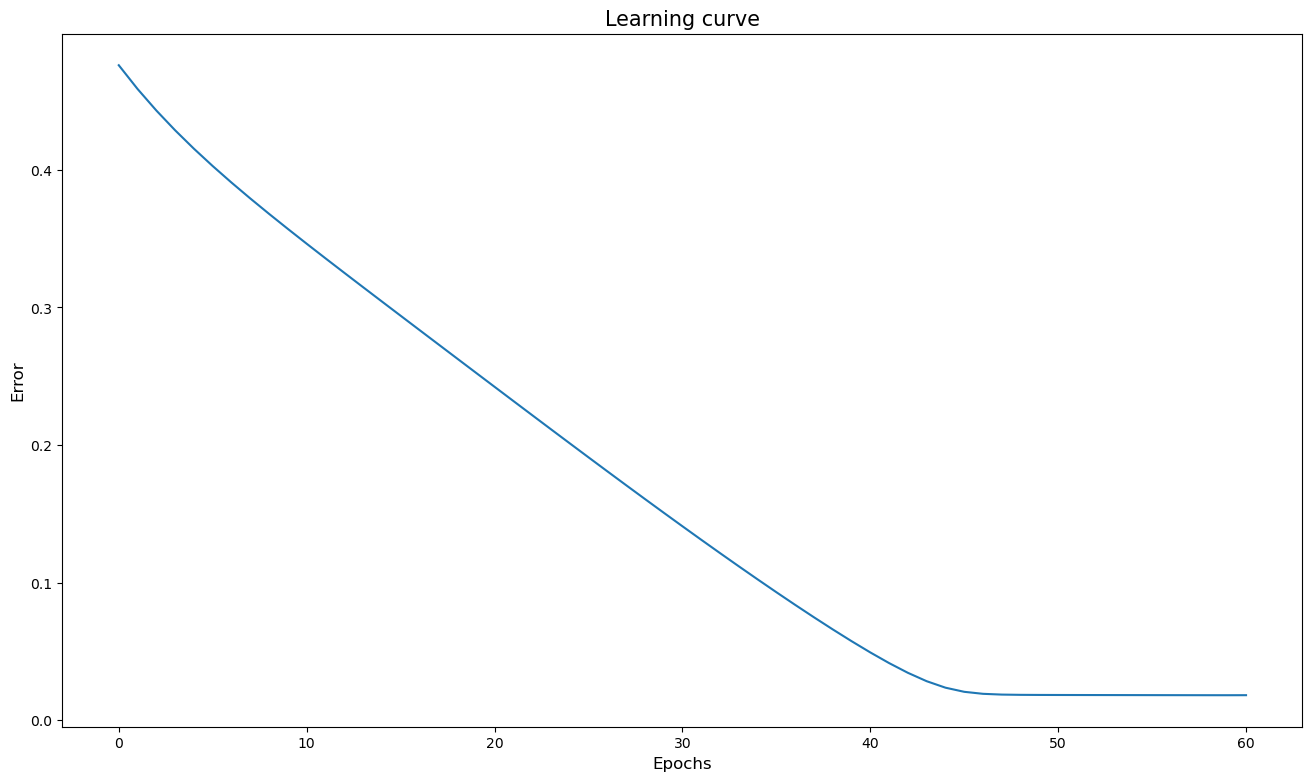

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title('Learning curve', fontsize=15)
plt.plot(points, [er.tolist() for er in errors])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)

plt.show()